In [1]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
from scipy.fft import fft, fftshift
from scipy.io import wavfile

In [2]:
Fs = 16e3
Fc = 2e3
v_sound = 343 # [m/s]

# Distancia entre sensores
d = [0.04, 0.08, 0.16]

subarray_sensors = [[3, 4, 5, 6, 7, 8,  9, 10, 11],
                    [1, 2, 3, 5, 7, 9, 11, 12, 13],
                    [0, 1, 3, 7, 11, 13, 14]]

M = [len(s) for s in subarray_sensors]

rate, data = wavfile.read('mtms-arrC1A.wav')
length = data.shape[0] / rate
N = len(data)
data = np.swapaxes(data,0,1) # Fila son canales, columnas son tiempo

C:\Users\Matias\AppData\Local\Temp/ipykernel_18732/426220646.py:4: UserWarning: Only one segment is calculated since parameter NFFT (=256) >= signal length (=15).
  plt.specgram( data_new, Fs=Fs)


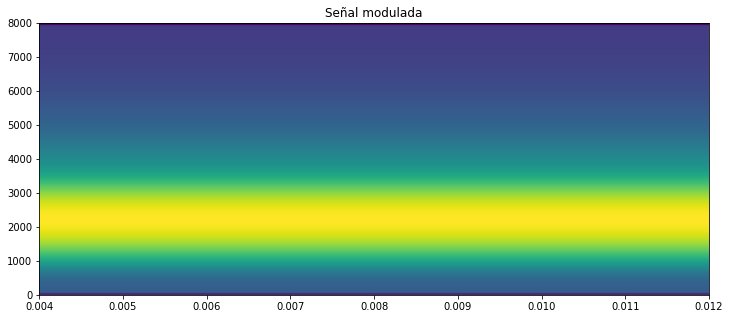

C:\Users\Matias\AppData\Local\Temp/ipykernel_18732/426220646.py:9: UserWarning: Only one segment is calculated since parameter NFFT (=256) >= signal length (=15).
  plt.specgram( data_new *  np.exp(-2j*np.pi*Fc/Fs* np.arange(len(data_new))), Fs=Fs)


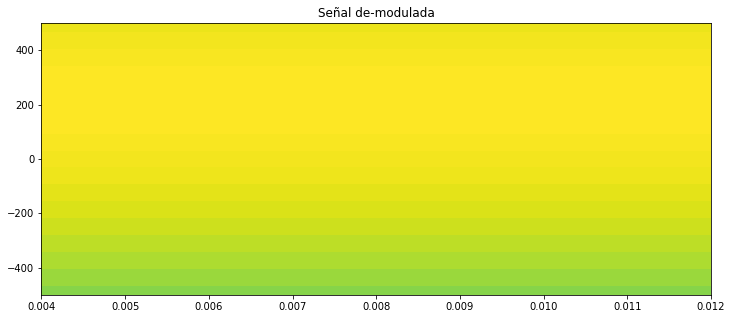

In [99]:
data_new = np.add(  np.swapaxes(data,0,1)[0] , 1000*np.cos(2 * np.pi * 2100/Fs * np.arange(len(data)))  )

plt.figure(figsize=(12, 5))
plt.specgram( data_new, Fs=Fs)
plt.title('Señal modulada')
plt.show()

plt.figure(figsize=(12, 5))
plt.specgram( data_new *  np.exp(-2j*np.pi*Fc/Fs* np.arange(len(data_new))), Fs=Fs)
plt.title('Señal de-modulada')
plt.ylim(-500, 500)
plt.show()

In [3]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = signal.lfilter(b, a, data)
    return y

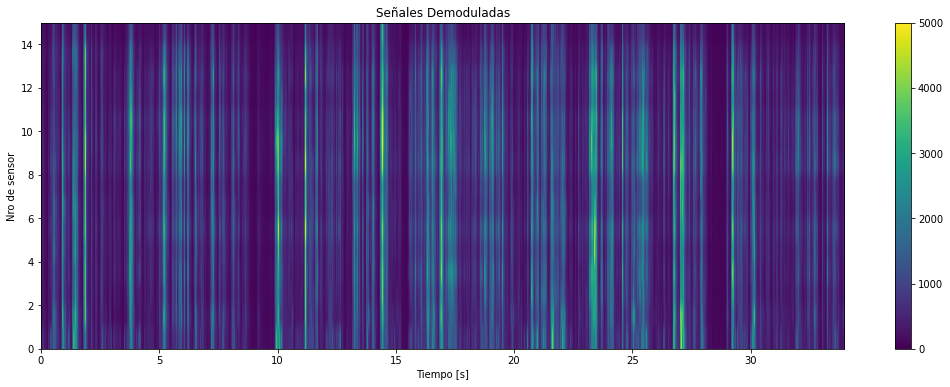

In [15]:
def v(phi, M, d):
    l = 343/Fc
    return M**-0.5 * np.exp(-2j * np.pi * d * np.sin(phi) / l * np.arange(0, M))

array_idx = 0
B = 1000     # pintó por ahora
phi_vector = np.linspace(-90, 90, 50)

b, a = butter_lowpass(B, Fs, 20)

data_demod = np.zeros(np.shape(data), dtype=np.complex_)
exp_demod = np.exp(2j*np.pi*Fc/Fs* np.arange(len(data[0])))
for i, val in enumerate(data):
    x = exp_demod * val
    data_demod[i] = signal.lfilter(b, a, x)

plt.figure(figsize=(18, 6))
img = plt.imshow( np.abs(data_demod), interpolation='antialiased', aspect='auto', vmax = 5e3, extent=[0, len(data[0])/Fs, 0, len(data_demod)])
plt.colorbar(img, ax=plt.gca())
plt.title('Señales Demoduladas')
plt.ylabel('Nro de sensor')
plt.xlabel('Tiempo [s]')
plt.show()

padding = 32-9
data_fft = np.zeros((M[array_idx] + padding, N), dtype=np.complex_)
for t in range(len(data_demod[0])):
    data_pad = np.pad( data_demod[ subarray_sensors[array_idx] , t], (0, padding) )
    data_fft[:, t] = fftshift( fft( data_pad ) )

plt.figure(figsize=(18, 6))
img = plt.imshow( np.abs(data_fft), interpolation='antialiased', aspect='auto', vmax = 5e3, extent=[0, len(data[0])/Fs, -0.5, 0.5])
plt.colorbar(img, ax=plt.gca())
plt.title('FFT espacial de las señales')
plt.ylabel('Frecuencia normalizada')
plt.xlabel('Tiempo [s]')
plt.show()


'''
x = np.linspace(0, len(data_fft[0])/Fs, len(data_fft[0])+1)
y = np.linspace(-0.5, 0.5, len(data_fft)+1)
y = np.arcsin(y*2) * 180/np.pi

X, Y = np.meshgrid(x, y)

plt.figure(figsize=(18, 6))
img = plt.pcolormesh(X, Y, np.abs(data_fft), vmax = 5e3, antialiased=True)
plt.colorbar(img, ax=plt.gca())
plt.title('FFT espacial de las señales')
plt.ylabel('Frecuencia normalizada')
plt.xlabel('Tiempo [s]')
plt.show()'''

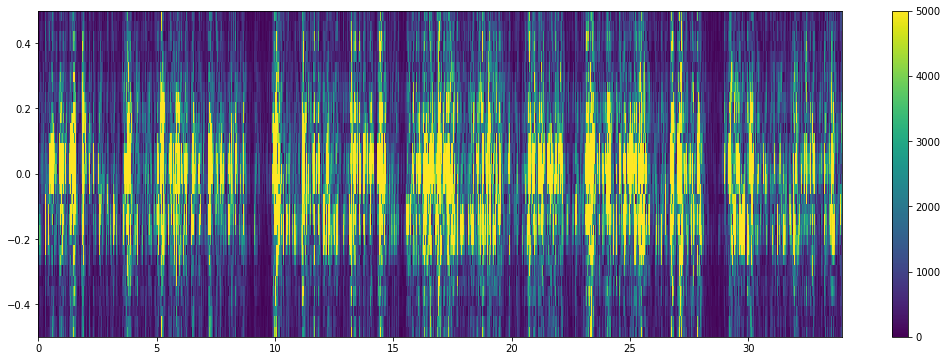

In [14]:
x = np.linspace(0, len(data_fft[0])/Fs, len(data_fft[0])+1)
y = np.linspace(-0.5, 0.5, len(data_fft)+1)
#y = np.arcsin(y*2) * 180/np.pi

X, Y = np.meshgrid(x, y)

plt.figure(figsize=(18, 6))
img = plt.pcolormesh(X, Y, np.abs(data_fft), vmax = 5e3, antialiased=True)
plt.colorbar(img, ax=plt.gca())
plt.show()

In [ ]:

'''
plt.figure(figsize=(18, 6))
plt.specgram(data[-1], Fs = Fs)
plt.title('Datos originales')
plt.show()

plt.figure(figsize=(18, 6))
plt.specgram(x, Fs = Fs)
plt.title('Datos demodulados')
plt.show()

plt.figure(figsize=(18, 6))
plt.specgram(data_demod[-1], Fs = Fs)
plt.title('Datos demodulados y pasabajeados')
plt.show()

plt.figure(figsize=(18, 6))
plt.plot(data[0])
plt.plot(data_demod[0])
plt.show()
'''


'''
matrix = []
for t in range(1, 16000):
    sensor_fft = []

    for phi in phi_vector:
        #c = v(phi, M[array_idx], d[array_idx])
        # No sé si hay que poner el -2j o +2j
        x = np.exp(-  2j*np.pi*Fc/Fs* t) * data[ t ][subarray_sensors[array_idx]]
        x_lp = signal.lfilter(b, a, x)
        sensor_fft.append( fft() )

    matrix.append(y)

plt.figure(figsize=(10, 10))
plt.imshow(np.abs( np.swapaxes(matrix,0,1)), interpolation='nearest', aspect='auto')'''


'''
B = 500     # pintó por ahora
c = 343
lmbda = c/B 
u = d[array_idx] * np.sin(phi) / lmbda
subarray = data[ subarray_sensors[array_idx] ]
'''

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Only one segment is calculated since parameter NFFT (=256) >= signal length (=15).
  after removing the cwd from sys.path.


Text(0.5, 0, 'Time [s]')

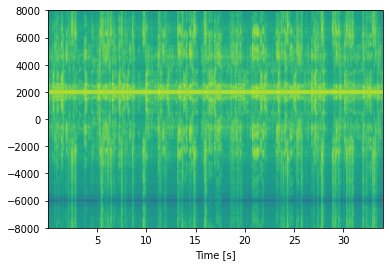

In [ ]:





v_phi= (1/np.sqrt(M_sub))*np.exp(-2j*np.pi*d*np.sin(phi_s)*np.arange(M_sub)/lmbda)

# print(new_data)
# print(f"number of new channels = {new_data.shape[1]}") # Si hago number_of_channels / fs = length del audio
N= new_data.shape[1] #cantidad de muestras en el tiempo
sq_spec, sq_freq, sq_t, sq_im = plt.specgram(new_data[0], Fs=Fs) #espectograma primer canal
modulated_data= new_data[0]* np.exp(2j*np.pi*Fc/Fs*np.arange(N))
sq_spec, sq_freq, sq_t, sq_im = plt.specgram(modulated_data, Fs=Fs)
plt.xlabel('Time [s]')
# pepe= v_phi.dot(subArray_data)


# fig, ax= plt.subplots(1,figsize=(20,20))
# ax.imshow(np.abs(pepe[:,:1000]))
# ax.set_yticks(range(0,100,10))
# ax.set_yticklabels(np.linspace(-90, 90, 10))